## 本程序读取train、validation、test的feature、label文件（在“datasets”文件夹下），然后构建网络进行超参数训练。输出在文件夹“hyper-param_tuning”中。

last update: 2021.9.7

contacts：zhaohf@ihep.ac.cn

# 配置环境

## 导入所需模块

In [1]:
import os
import sys
assert sys.version_info >= (3, 5)
#
import pandas as pd
import numpy as np
#
# TensorFlow ≥2.0 is required
import tensorflow as tf
assert tf.__version__ >= "2.0"
import sklearn

from tensorflow import keras
from tensorflow.keras import optimizers
#
# pydot_ng and graphviz are for tf.keras.utils.plot_model
# note that installing pydot_ng is 'pydot-ng'
# note that 在windows下不可以使用pip install graphviz 下载graphviz安装包，
# 要去https://graphviz.gitlab.io/下载windows版本的安装包，安装好之后在环境变量中添加对应的路径即可！！！
import graphviz
import pydot
import pydot_ng
#
import time

ModuleNotFoundError: No module named 'tensorflow'

输出导入模板的版本。

In [3]:
print('python version:',sys.version)
print('TensorFlow version:',tf.__version__)
print('sciket learn version:',sklearn.__version__)
print('numpy version:',np.__version__)
print('panda version:',pd.__version__)
print('graphviz version:',graphviz.__version__)
print('pydot version:',pydot.__version__)
print('pydot_ng version:',pydot_ng.__version__)
#
#print('matplotlib version:',matplotlib.__version__)
#print('time version:',time.__version__)

python version: 3.8.8 (default, Apr 13 2021, 15:08:03) [MSC v.1916 64 bit (AMD64)]
TensorFlow version: 2.5.0
sciket learn version: 0.24.1
numpy version: 1.19.5
panda version: 1.2.4
graphviz version: 0.17
pydot version: 1.4.2
pydot_ng version: 2.0.0


## 配置输入文件夹

设置train、validation、test的文件夹路径和文件名

In [11]:
dir_data = 'datasets'
file_train = ['Au_chi_train.txt', 'Au_cn_train.txt']
file_valid = ['Au_chi_valid.txt', 'Au_cn_valid.txt']
file_test = ['Au_chi_test.txt', 'Au_cn_test.txt']

## 配置输出文件夹

所有输出文件都保存在一个文件夹内

In [4]:
dir_output = 'hyper-param_tuning'

设置文件夹放置模型

In [5]:
#dir_model = 'model'
dir_model = dir_output
path_model = os.path.join(os.curdir, dir_model)
os.makedirs(path_model, exist_ok=True)

设置文件夹放置图片

In [6]:
#dir_images = 'images'
dir_images = dir_output
path_images = os.path.join(os.curdir, dir_images)
os.makedirs(path_images, exist_ok=True)

设置文件夹放置分析结果

In [7]:
#dir_ana = 'analysis'
dir_ana = dir_output
path_ana = os.path.join(os.curdir, dir_ana)
os.makedirs(path_ana, exist_ok=True)

设置文件夹放置预测结果

In [43]:
#dir_pre = 'data'
dir_pre = dir_output
path_pre = os.path.join(os.curdir, dir_pre)
os.makedirs(path_pre, exist_ok=True)

设置日志文件的文件夹，为TensorBoard使用。

In [8]:
# 设置日志文件的文件夹
root_logdir = os.path.join(os.curdir, "my_logs")
#print(root_logdir)
#
def get_run_logdir():
#    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

  确保绘制的图形美观、能保存下来。

In [9]:
# To plot pretty figures
# %matplotlib具体作用是调用matplotlib.pyplot的绘图函数plot()进行绘图时，
# 或生成一个figure画布时，可以直接在你的python console里面生成图像。
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)   # matplotlib.rc 什么意思没找到
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
#PROJECT_ROOT_DIR = "."
#path_images = os.path.join(PROJECT_ROOT_DIR, "images")
#os.makedirs(path_images, exist_ok=True)

def save_fig(fig_id, path_fig = path_images, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(path_fig, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

## 设置label标签，用于后面模型训练、绘图

In [12]:
label_index = 'CN'

# 正文

## 确定当前目录和工作目录

In [10]:
import os
path = os.path.abspath(os.curdir)
path

'D:\\haifeng\\work_20210709\\ML+XAS\\code\\neural network module\\latest'

## 检查输入文件是否存在

In [13]:
path_dir_data = os.path.join(path,dir_data)
file_data = file_train + file_valid + file_test
#
for i in range(len(file_data)):
    path_file = os.path.join(path_dir_data,file_data[i])
#
# 检查csv是否存在，若不存在，报错
    exist = os.path.exists(path_file)
    if not exist:
        print()
        print(f"** Error!! cannot find file {file_data[i]} in directory {dir_data}! **")
        print()
        sys.exit()

## 读取train、valid等文件，制成数据集。

In [14]:
import pandas as pd
for i in range(len(file_data)):
    path_file = os.path.join(path_dir_data,file_data[i])
#   df.values, df.as_matrix() and np.array(df) all works.
    data_df = pd.read_csv(path_file,header=None,delim_whitespace=True)
#
    if i == 0 : feature_train = data_df.values
    if i == 1 : label_train = data_df.values
    if i == 2 : feature_valid = data_df.values
    if i == 3 : label_valid = data_df.values
    if i == 4 : feature_test = data_df.values
    if i == 5 : label_test = data_df.values

In [15]:
print(feature_train.shape, label_train.shape)
print(feature_valid.shape, label_valid.shape)
print(feature_test.shape, label_test.shape)

(4176, 400) (4176, 1)
(1193, 400) (1193, 1)
(597, 400) (597, 1)


In [16]:
feature_train

array([[ 3.204381e-01,  3.179742e-01,  3.107868e-01, ...,  1.588940e-06,
         1.217988e-06,  8.223206e-07],
       [ 2.272433e-01,  2.254551e-01,  2.202515e-01, ..., -1.081169e-06,
        -1.537145e-06, -1.827965e-06],
       [ 2.434066e-01,  2.416660e-01,  2.365912e-01, ...,  1.017455e-06,
         9.860825e-07,  8.813536e-07],
       ...,
       [ 2.441422e-01,  2.422082e-01,  2.365669e-01, ..., -1.025576e-06,
        -8.874537e-07, -7.067118e-07],
       [ 7.773254e-02,  7.687764e-02,  7.436020e-02, ...,  3.263314e-07,
         2.805082e-07,  2.240872e-07],
       [ 3.252115e-01,  3.225673e-01,  3.148726e-01, ...,  7.640049e-07,
         1.259443e-06,  1.596963e-06]])

In [17]:
label_valid

array([[ 8],
       [ 9],
       [ 8],
       ...,
       [12],
       [12],
       [ 8]], dtype=int64)

设置网络训练参数值，输入数组维数

In [18]:
input_shape = feature_train.shape[1:]
input_shape

(400,)

## 构建模型（神经网络），进行超参数调节

### 模型1

#### 参量设置

输入超参数训练模型的关键词，用于命名给出训练过程信息的文件名

In [19]:
model_pre = 'au150_DW_cn_3level_neuron'

In [20]:
import time
model_time = time.strftime("run_%Y_%m_%d-%H_%M_%S")
model_pre_time = model_pre + '_' + model_time
path_plot = os.path.join(path_images, model_pre_time)
os.makedirs(path_plot, exist_ok=True)

In [21]:
file_fitinfo =  model_pre_time + '_fitinfo.txt'
path_fitinfo = os.path.join(path_ana,file_fitinfo)

In [22]:
fout = open(path_fitinfo,'w')
print(f"Model : {model_pre}")
print(f"Model : {model_pre}", file=fout)

Model : au150_DW_cn_3level_neuron


In [23]:
# Set random seed to be used as argument for other functions.
rseed = 42

In [24]:
print(f"===================================")
print(f"\n===================================", file=fout)
print(f"rseed : {rseed}")
print(f"rseed : {rseed}",file=fout)
print(f"Time : {model_time}")
print(f"Time : {model_time}",file=fout)

rseed : 42
Time : run_2021_09_07-08_50_58


In [25]:
import tensorflow as tf
assert tf.__version__ >= "2.0"
from tensorflow import keras
from tensorflow.keras import optimizers
keras.backend.clear_session()
np.random.seed(rseed)
tf.random.set_seed(rseed)

In [26]:
run_logdir = get_run_logdir()
run_logdir

'.\\my_logs\\run_2021_09_07-08_51_52'

#### 构建模型

In [27]:
def build_model(N1 = 400,
                N2 = 200,
                N3 = 20,
                activation = 'relu',
#                learning_rate = 3e-3,
                input_shape=input_shape):
#
    model = keras.models.Sequential()
#
    model.add(keras.layers.Flatten(input_shape=input_shape))
    model.add(keras.layers.Dense(N1, activation=activation))
    model.add(keras.layers.Dense(N2, activation=activation))
    model.add(keras.layers.Dense(N3, activation=activation))
    model.add(keras.layers.Dense(1, activation=activation))
#
#    optimizer = keras.optimizers.SGD(lr=learning_rate)
#    optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9, momentum=0.0, epsilon=1e-07, centered=False,name='RMSprop')
#    model.compile(loss="mse", optimizer=optimizer)
    model.compile(loss="mse", optimizer='rmsprop')
    return model

用函数 build_model() 创建一个 KerasRegressor，它通过 build_model() 将Keras模型包装起来的。

In [28]:
keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)

注意！不要将类似“"N1": range(1, 600)”写成“"N1": np.arange(1, 600)”或“"N1": list(np.range(1, 600))”的情况，不然在fit的结尾，会出现如下问题：

而且“model = rnd_search_cv.best_estimator_.model”等无法加载。
但需要指出，最后的“rnd_search_cv.best_params_”等是一样的

In [29]:
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report

param_distribs = {
#    "kernel_size": [3, 4, 5, 6],
#    "padding" = ['valid', 'SAME'],
#    "n_hidden": [0, 1, 2, 3],
#    "activation": ['relu','softmax'],
    "N1": range(10, 600, 10),
    "N2": range(10, 600, 10),
    "N3": range(10, 600, 10)
#    "learning_rate": reciprocal(3e-4, 3e-2),
}

# n_iter=300，训练300次，数值越大，获得的参数精度越大，但是搜索时间越长
# cv 训练集与验证集的比值
# verbose=0，不打印任何训练过程信息；verbose=1，打印进度条；verbose=2，每一个epoch打印一次。
# n_jobs = -1，使用所有的CPU进行训练，默认为1，使用1个CPU
#rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, n_iter=20, cv=3, verbose=2, n_jobs=-1)
rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, n_iter=20, verbose=1, n_jobs=-1)
#rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, n_iter=20, verbose=1)

#### 开始拟合

In [30]:
#将训练最好的模型保存下来
model_saved_best = os.path.join(path_model, model_pre_time + ".h5")
#
rnd_search_cv.fit(feature_train,label_train,epochs=200,
                  validation_data=(feature_valid,label_valid),
                  callbacks=[keras.callbacks.ModelCheckpoint(model_saved_best, save_best_only=True),
                             keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True),
                             keras.callbacks.TensorBoard(run_logdir)
                            ],
                  verbose=0)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [         nan -18.32092522          nan -36.11937456          nan
 -18.02869737 -36.10222878          nan -36.03232981 -36.19578846
 -36.03215091 -18.1470016  -18.25681961  -0.30155271          nan
 -36.14840611 -36.00196541 -18.33551311 -54.09905769  -0.35488775]
  warnings.warn(


RandomizedSearchCV(estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x0000023809D50250>,
                   n_iter=20, n_jobs=-1,
                   param_distributions={'N1': range(10, 600, 10),
                                        'N2': range(10, 600, 10),
                                        'N3': range(10, 600, 10)},
                   verbose=1)

executed in 38m 36s, finished 14:49:36 2021-03-01
Fitting 5 folds for each of 20 candidates, totalling 100 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 10.3min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 37.9min finished
RandomizedSearchCV(estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x0000029136552640>,
                   n_iter=20, n_jobs=-1,
                   param_distributions={'N1': range(1, 600),
                                        'N2': range(1, 600),
                                        'N3': range(1, 600)},
                   verbose=2)

#### 给出拟合结果

In [31]:
# Parameter setting that gave the best results on the hold out data.
#rnd_search_cv.best_params_
print(f"Best parameters : {rnd_search_cv.best_params_}")
print(f"\nBest parameters : {rnd_search_cv.best_params_}",file=fout)

Best parameters : {'N3': 580, 'N2': 570, 'N1': 550}


In [32]:
# 返回最优的训练器
# Estimator that was chosen by the search, i.e. estimator which gave highest score (or smallest loss if specified) on the left out data.
rnd_search_cv.best_estimator_

In [33]:
# Mean cross-validated score of the best_estimator.
#rnd_search_cv.best_score_
print(f"Best score : {rnd_search_cv.best_score_}")
print(f"\nBest score : {rnd_search_cv.best_score_}",file=fout)

Best score : -0.3015527129173279


Best score : -0.282334824403127

Best score = -0.2784130076567332

原来是-0.0010918860401337345

#### 输出拟合日志文件

In [34]:
# rnd_search_cv.cv_results_ 是选择参数的日志信息
cv_result = pd.DataFrame.from_dict( rnd_search_cv.cv_results_)
file_fit_csv = model_pre_time + '_fit.csv'
path_fit_csv = os.path.join(path_ana, file_fit_csv)
with open(path_fit_csv,'w') as f: cv_result.to_csv(f)
3#print(rnd_search_cv.cv_results_)

3

In [35]:
# Seconds used for refitting the best model on the whole dataset.
#rnd_search_cv.refit_time_
print(f"Refit time (s) : {rnd_search_cv.refit_time_}")
print(f"\nRefit time (s) : {rnd_search_cv.refit_time_}",file=fout)

Refit time (s) : 152.54528427124023


In [34]:
#y_pred_array = rnd_search_cv.predict(feature_test) # 预测结果
#print(classification_report( y_true=label_test, y_pred=y_pred_array ))

#### 用给出的最佳（参数）模型对test数据集进行预测

In [36]:
model0 = rnd_search_cv.best_estimator_.model
model0

查看预测结果

In [37]:
model0.evaluate(feature_test, label_test)

19/19 [==============================] - 0s 3ms/step - loss: 0.3205


0.3204747438430786

19/19 [==============================] - 0s 780us/step - loss: 0.2871
0.28713077306747437

19/19 [==============================] - 0s 1ms/step - loss: 89.5477
89.54773712158203

19/19 [==============================] - 0s 891us/step - loss: 0.2962
0.2962176203727722

rnd_search_cv.predict(feature_test) works as rnd_search_cv.best_estimator_.model.predict(feature_test)

In [38]:
pre0 = model0.predict(feature_test)
pre0

array([[ 8.277572 ],
       [ 8.196247 ],
       [ 7.9759154],
       [ 7.4522448],
       [ 5.9448752],
       [11.466561 ],
       [ 9.088181 ],
       [12.80579  ],
       [11.803331 ],
       [ 7.770665 ],
       [ 7.251605 ],
       [14.5755625],
       [11.562111 ],
       [ 5.9306636],
       [12.212166 ],
       [11.805087 ],
       [ 9.057611 ],
       [ 4.7563505],
       [11.336695 ],
       [11.98055  ],
       [ 8.210878 ],
       [ 7.688798 ],
       [ 7.924697 ],
       [ 7.728961 ],
       [ 5.445059 ],
       [11.612305 ],
       [ 7.286895 ],
       [13.288922 ],
       [ 7.796979 ],
       [ 7.9255476],
       [12.556916 ],
       [11.843674 ],
       [11.864285 ],
       [ 8.000217 ],
       [ 5.980237 ],
       [14.735621 ],
       [ 9.270783 ],
       [ 6.7726464],
       [ 7.9731593],
       [12.133048 ],
       [12.231118 ],
       [ 6.727536 ],
       [ 7.822253 ],
       [ 9.157296 ],
       [11.720641 ],
       [12.230541 ],
       [12.602926 ],
       [ 8.29

In [39]:
def pre_ana(pre, label_test):
    """
    """
    diff = pre - label_test
    diff_abs = np.abs(diff)
    diff2 = np.square(diff)  # = diff**2
    #pre_var_mean = np.mean(diff2, axis=0)
    pre_var_mean = np.mean(diff2)
    pre_var_std = np.sqrt(pre_var_mean)  # = pre_var_mean**0.5
    err = diff / label_test
    err_abs = np.abs(err)
    attr_dict3 = {
        'diff_Max': np.max(diff),
        'diff_Min': np.min(diff),
        '|diff|_Mean(MAE)': np.mean(diff_abs),
        '|diff|_Max': np.max(diff_abs),
        '|diff|_Min': np.min(diff_abs),
        'pre_Var(MSE)': pre_var_mean,
        'pre_Std(RMSE)': pre_var_std,
        'Error_mean': np.mean(err),
        'Error_max': np.max(err),
        'Error_min': np.min(err),
        '|Error|_mean(MAPE)': np.mean(err_abs),
        '|Error|_max': np.max(err_abs),
        '|Error|_min': np.min(err_abs)
    }
    return attr_dict3, err

In [40]:
a, err = pre_ana(pre0, label_test)
print("Prediction:")
print("\nPrediction:",file=fout)
for key in a.keys():
    print(f"  {key:<20}: {a[key]:>11.7f}")
    print(f"  {key:<20}: {a[key]:>11.7f}",file=fout)

Prediction:
  diff_Max            :   5.5915737
  diff_Min            :  -2.0134583
  |diff|_Mean(MAE)    :   0.3444215
  |diff|_Max          :   5.5915737
  |diff|_Min          :   0.0002174
  pre_Var(MSE)        :   0.3204748
  pre_Std(RMSE)       :   0.5661049
  Error_mean          :   0.0159238
  Error_max           :   5.5915737
  Error_min           :  -0.2013458
  |Error|_mean(MAPE)  :   0.0530340
  |Error|_max         :   5.5915737
  |Error|_min         :   0.0000272


#### 查看拟合中保存的最佳模型

是否与上述模型一样？

In [41]:
print(f"Saved best model : {model_saved_best}")
print(f"\nSaved best model : {model_saved_best}",file=fout)
fout.close()

Saved best model : .\hyper-param_tuning\au150_DW_cn_3level_neuron_run_2021_09_07-08_50_58.h5


In [42]:
model = keras.models.load_model(model_saved_best)
model

In [43]:
pre = model.predict(feature_test)
pre

array([[ 8.277572 ],
       [ 8.196247 ],
       [ 7.9759154],
       [ 7.4522448],
       [ 5.9448752],
       [11.466561 ],
       [ 9.088181 ],
       [12.80579  ],
       [11.803331 ],
       [ 7.770665 ],
       [ 7.251605 ],
       [14.5755625],
       [11.562111 ],
       [ 5.9306636],
       [12.212166 ],
       [11.805087 ],
       [ 9.057611 ],
       [ 4.7563505],
       [11.336695 ],
       [11.98055  ],
       [ 8.210878 ],
       [ 7.688798 ],
       [ 7.924697 ],
       [ 7.728961 ],
       [ 5.445059 ],
       [11.612305 ],
       [ 7.286895 ],
       [13.288922 ],
       [ 7.796979 ],
       [ 7.9255476],
       [12.556916 ],
       [11.843674 ],
       [11.864285 ],
       [ 8.000217 ],
       [ 5.980237 ],
       [14.735621 ],
       [ 9.270783 ],
       [ 6.7726464],
       [ 7.9731593],
       [12.133048 ],
       [12.231118 ],
       [ 6.727536 ],
       [ 7.822253 ],
       [ 9.157296 ],
       [11.720641 ],
       [12.230541 ],
       [12.602926 ],
       [ 8.29

In [44]:
diff_pre = pre0-pre
diff_pre

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],

In [45]:
small = 0.0001
if np.max(np.abs(pre0 - pre)) > small:
    different = True
else:
    different = False

In [46]:
if different:
    b, err = pre_ana(pre, label_test)
    fout = open(path_fitinfo, 'a')
    print("Prediction(Saved model):")
    print("\nPrediction(Saved model):", file=fout)
    for key in b.keys():
        print(f"  {key:<20}: {b[key]:>11.7f}  VS  {a[key]:>11.7f}  diff= {(b[key]-a[key]):>11.7f}")
        print(f"  {key:<20}: {b[key]:>11.7f}  VS  {a[key]:>11.7f}  diff= {(b[key]-a[key]):>11.7f}", file=fout)
    fout.close()

## 将本来值、预测值输出到文件中

In [ ]:
file_pre_txt =  model_pre_time + '_pre.txt'
path_pre_txt = os.path.join(path_pre,file_pre_txt)

In [ ]:
fout = open(path_pre_txt,'w')
str_no = 'No.'
str_lab = 'Label'
str_pre = 'Pre_best'
str_diff = 'Diff'
str_err = 'Error'
str_pre2 = 'Pre_saved'
str_pre_diff = 'Pre_diff'
print(f"{str_no:>5} {str_lab:>5} {str_pre:>8} {str_diff:>8} {str_err:>10} {str_pre2:>8} {str_pre_diff:>8}")
print(f"{str_no:>5} {str_lab:>5} {str_pre:>8} {str_diff:>8} {str_err:>10} {str_pre2:>8} {str_pre_diff:>8}", file=fout)

In [ ]:
for i in range(pre.size):
    print(f"{i+1:>5d} {label_test[i][0]:>5.1f} {pre0[i][0]:>8.4f} {diff[i][0]:>8.4f} {err[i][0]:>11.3E} {pre[i][0]:>8.4f} {diff_pre[i][0]:>8.4f}")
    print(f"{i+1:>5d} {label_test[i][0]:>5.1f} {pre0[i][0]:>8.4f} {diff[i][0]:>8.4f} {err[i][0]:>11.3E} {pre[i][0]:>8.4f} {diff_pre[i][0]:>8.4f}", file=fout)
#    fout.write(f"{i:>5d} {label_test[i]:>11.7f} {pre[i]:>11.7f} {diff[i]:>11.7f} {err[i]:>11.3E}\n")
fout.close()

#### 预测test的图形比较

In [47]:
def plot_PredictionError(ylim,ind=0):
    """
    """
#
    prediction_error = model_pre + "_prediction_error" + f"_{ind}"
    plt.plot(err, label = f'{label_index}')
    plt.xlabel('Test series')
    plt.ylabel('Error')
    plt.ylim(ylim)
    plt.legend(loc='upper left',fontsize=12)
    plt.title(f"{model_pre}\nPrediction Error", fontsize=16)
    save_fig(prediction_error, path_plot)

Saving figure au150_DW_cn_3level_neuron_prediction_error_0


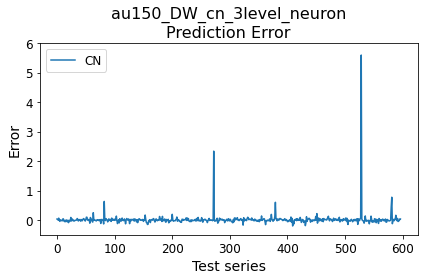

In [49]:
plot_PredictionError([-0.5,6],ind=0)

Saving figure au150_DW_cn_3level_neuron_prediction_error_2


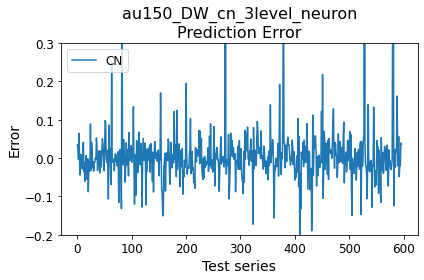

In [50]:
plot_PredictionError([-0.2,0.3],ind=2)

直接比较

原来代码

#x_low and x_high are the border of x-axis for plotting
x_low = 0
x_high = 50
#x_ticks is the step show for x-axis plottong
x_ticks = 10
prediction_compare = model_pre + f"_prediction_compare_{label_index}_{x_low}_{x_high}"
x = range(pre.shape[0])
plt.figure(figsize=(8, 8))
plt.scatter(x,label_test, marker='o', label = f'{label_index}')
plt.scatter(x,pre, marker='^', label = f'{label_index}_pre')
plt.xlabel('Test series')
plt.ylabel(f'{label_index}')
plt.xlim(x_low,x_high)
plt.ylim(min(np.min(label_test),np.min(pre)), max(np.max(label_test),np.max(pre)))
plt.xticks(np.arange(x_low,x_high+1,x_ticks), rotation=0)#rotation控制倾斜角度
#plt.yticks(np.arange(np.max(label_test)-1, np.max(label_test)+1, 2))
#plt.yticks(np.arange(np.around(np.min(label_test),1)-0.1, np.around(np.max(label_test),1)+0.1, 0.2))
#plt.legend(loc='lower right')
plt.legend(loc='upper right', fontsize=12)
plt.title(f"{model_pre}\nRegression Performance", fontsize=16)
save_fig(prediction_compare, path_plot)

In [51]:
def plot_PredictionCompare(x_low, x_high, x_ticks=10):
    """
    """
#
    prediction_compare = model_pre + f"_prediction_compare_{label_index}_{x_low}_{x_high}"
    x = range(pre.shape[0])
    plt.figure(figsize=(8, 8))
    plt.scatter(x,label_test, marker='o', label = f'{label_index}')
    plt.scatter(x,pre, marker='^', label = f'{label_index}_pre')
    plt.xlabel('Test series')
    plt.ylabel(f'{label_index}')
    plt.xlim(x_low,x_high)
    plt.ylim(min(np.min(label_test),np.min(pre)), max(np.max(label_test),np.max(pre)))
    plt.xticks(np.arange(x_low,x_high+1,x_ticks), rotation=0)#rotation控制倾斜角度
#plt.yticks(np.arange(np.max(label_test)-1, np.max(label_test)+1, 2))
#plt.yticks(np.arange(np.around(np.min(label_test),1)-0.1, np.around(np.max(label_test),1)+0.1, 0.2))
    plt.legend(loc='upper right', fontsize=12)
    plt.title(f"{model_pre}\nRegression Performance", fontsize=16)
    save_fig(prediction_compare, path_plot)

In [ ]:
step = 50
for i in range(0,pre.size, step):
    plot_PredictionCompare(i, min(i+step, pre.size))